# XGB test

In [1]:
%load_ext autoreload
%autoreload 2

# %matplotlib widget

In [3]:
import pandas as pd

import seaborn as sns

from math import log, floor

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from xgboost import XGBRegressor
import shap


from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

from plots2.fns import (
    # standard_layout,
    # corner_annotations_colwise,
    # corner_annotations_rowwise,
    # get_text_annotation,
    get_corner_annotations,
    get_corner_annotations_custom_labels,
    # get_corner_annotations_explicit
)

from plots2.consts import (
    SMALL_FONT,
    MEDIUM_FONT,
    BIGGER_FONT,
    SHAP_BLUE
)

from poly2.utils import trait_vec, gamma_dist, object_dump, object_load, load_train_test_data
from poly2.config import Config, ConfigMixture, get_asymptote_config

In [4]:
X_cv, y_cv, X_test, y_test = load_train_test_data('all')

## Squared error

In [6]:
%%time

xgb = XGBRegressor()

xgb.load_model('../outputs/xgb/all.json')

Wall time: 1.67 s


In [7]:
%%time

xgb.fit(X_cv, y_cv)

y_p = xgb.predict(X_test)

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


Wall time: 2min 9s


## Compare with Pseudo huber error

In [5]:
hyperparams = (
    pd.read_csv('../outputs/hyperparams/all.csv')
    .iloc[0]
    .to_dict()
)

hyperparams['max_depth'] = int(hyperparams['max_depth'])
hyperparams['n_estimators'] = int(hyperparams['n_estimators'])

hyperparams['objective'] = 'reg:pseudohubererror'

hyperparams

{'max_depth': 16,
 'n_estimators': 10,
 'learning_rate': 0.0371213285319188,
 'subsample': 0.8744019412693059,
 'colsample_bytree': 0.6991042073815543,
 'objective': 'reg:pseudohubererror'}

In [9]:
%%time

xgb2 = XGBRegressor(**hyperparams)

xgb2.fit(X_cv, y_cv)

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


Wall time: 2min 21s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.943486029986996,
             enable_categorical=False, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.0182387397607204,
             max_delta_step=0, max_depth=10, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=853, n_jobs=8,
             num_parallel_tree=1, objective='reg:pseudohubererror',
             predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=0.721624617726085,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [10]:
y_p2 = xgb2.predict(X_test)

## Plot

In [11]:
mean_squared_error(y_p, y_test[:, 0], squared=False)

0.1086953213543925

In [12]:
mean_squared_error(y_p2, y_test[:, 0], squared=False)

0.10868153916874275

In [13]:
pdf = pd.DataFrame(dict(
    Model=y_p,
    Model2=y_p2,
    Data=y_test[:, 0],
))

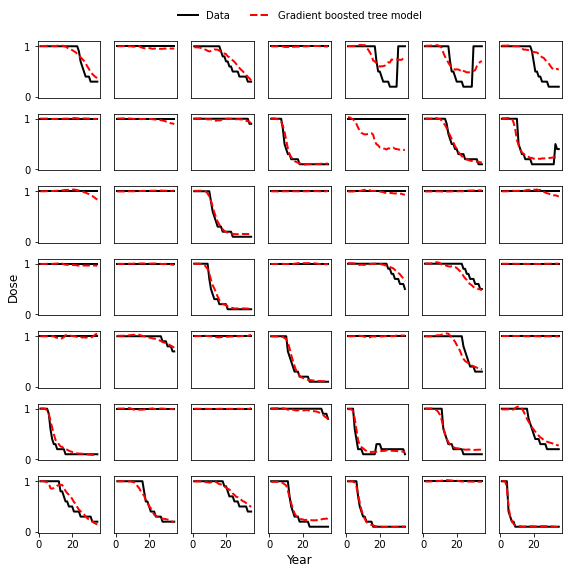

In [14]:
plt.rc('font', size=SMALL_FONT)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_FONT)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_FONT)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_FONT)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_FONT)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_FONT)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_FONT)  # fontsize of the figure title

rows = 7
cols = 7

f, ax = plt.subplots(rows, cols, figsize=(8,8))

for ii in range(rows*cols):
    data = pdf.iloc[35*ii:35*(ii+1)].assign(year = np.arange(1,36))
    
    rr = floor(ii/rows)
    cc = ii%cols

    ax[rr][cc].plot(data.year, data.Data, c='k', lw=2, label='Data')
    ax[rr][cc].plot(data.year, data.Model, c='r', ls='--', lw=2, label='Gradient boosted tree model')
    # ax[rr][cc].plot(data.year, data.Model2, c='b', ls='--', lw=2)
    
    ax[rr][cc].set_ylim([-0.02, 1.1])
    
    if rr<rows-1:
        ax[rr][cc].set_xticks([])
    
    if cc>0:
        ax[rr][cc].set_yticks([])
    
    if rr==3 and cc==0:
        ax[rr][cc].set_ylabel('Dose')

    if cc==3 and rr==rows-1:
        ax[rr][cc].set_xlabel('Year')
        
        

plt.tight_layout(rect=[0,0,1,0.95])

ax[0][0].legend(
    loc='lower left',
    bbox_to_anchor=(2.1, 1.2),
    ncol=2,
    framealpha=0,
)

# Save

In [15]:
f.savefig('../figures/paper/appm_fig1.jpg', dpi=300, bbox_inches="tight")